In [2]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m

from importlib import reload  # Python 3.4+

from sklearn.linear_model import Lasso

In [6]:
# reload helper and methods for when things change
reload(m);
reload(h);

True W:
[[ 0.75  0.    0.    0.  ]
 [-0.35  0.75  0.    0.  ]
 [-0.36  0.25  0.75  0.  ]
 [ 0.    0.    0.    0.75]].



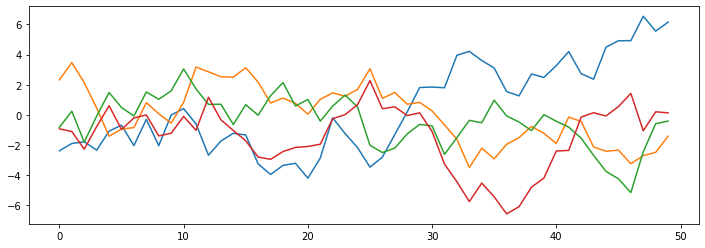

In [7]:
# np.random.seed(seed = 1235)

## Number of dimensions, number of edges, number of samples
T, p, s = 50, 4, 3

N = int(p * (p + 1) / 2)

### Coefficient matrix
## First approach: A is a DAG, no model mismatch
A_true = h.generate_A(p, s, tril = True, low = 0.25, high = 0.50)

# set coefficients to be positive (else oscillating which does not make sense)
for i in range(len(A_true)):
    A_true[i][i] = 0.75 # np.abs(A_true[i][i])

s = len(A_true.flatten().nonzero()[0])

## True permutation
P_true = np.identity(p) # np.random.permutation(np.identity(n))

## Datagenerating W
W_true = P_true.T @ A_true @ P_true
print(f"True W:\n{np.round(W_true, 2)}.\n")

## Generate series
X = h.gen_var(W_true, T)
plt.figure(figsize = (12, 4))
plt.plot(X);

[[ 0.8  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.8  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.8  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5 -0.5  0.   0.8  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5 -0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.   0.5 -0.5  0.   0.   0.   0.   0. ]
 [-0.5 -0.5  0.   0.5  0.5  0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.5  0.5  0.5  0.   0.   0.   0.   0. ]
 [-0.5  0.   0.5 -0.5 -0.5  0.   0.   0.   0.   0. ]
 [ 0.5  0.5 -0.5  0.   0.5  0.5  0.   0.   0.   0. ]]


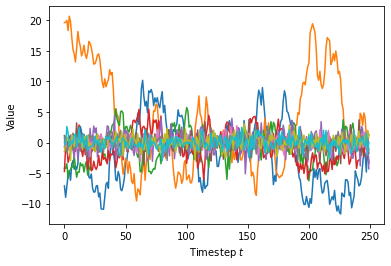

In [25]:
np.random.seed(seed = 12345)

# Number of dimensions, number of edges, number of samples
T, p, s = 250, 10, 25
N = int(p * (p + 1) / 2)

### Coefficient matrix
W_true = h.generate_A(p, s, tril = True, low = 0.50, high = 0.50)

for i in range(len(A_true)):
    W_true[i][i] = 0.80 # np.abs(A_true[i][i])
print(np.round(W_true, 1))

s = len(W_true.flatten().nonzero()[0])

## Generate series
X = h.gen_var(W_true, T)

## Plot series
plt.xlabel(r"Timestep $t$")
plt.ylabel(r"Value")
plots = plt.plot(X); 

In [26]:
# use OMP to estimate
# T = 250
# X = h.gen_var(W_true, T)
W, _ = m._K_OMP(X[:-1], X[1:], normalize = True, F = [])
W_L = constrained_LASSO(W != 0, X, alpha = 0.3)

h.score(X, W_L, W_true);
print(np.round(W_L != 0))
print(np.round(W_true != 0))


True Positive Rate: 1.0.
True Negative Rate: 0.986.
False Prediction Rate: 0.033
Accuracy: 0.99.
R-Squared: 0.902
Mean Squared Error: 12.128
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 0. 0. 0.]]


In [10]:
def constrained_LASSO(B, X, alpha = 0.1):
    p = np.shape(B)[0]
    clf = Lasso(alpha = alpha, fit_intercept = False)
    W_cons = np.zeros((p, p))
    
    for i in range(p):
        idx = np.where(B[:, i] != 0)[0]
        clf.fit(X[:-1, idx], X[1:, i])
        W_cons[idx, i] = clf.coef_
    
    return W_cons

print(W)
constrained_LASSO(W != 0, X)

[[ 0.79722953  0.0325246   0.02064992  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.81730959  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         -0.48168568  0.81982609  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.48880534 -0.50127932 -0.01727209  0.83280467  0.          0.
   0.          0.          0.          0.        ]
 [-0.01250788  0.01230959  0.5081404  -0.49253684 -0.0112267   0.
   0.          0.          0.          0.        ]
 [ 0.07357189  0.61645509 -0.00188404  0.4485055  -0.46642796 -0.05794522
   0.          0.          0.          0.        ]
 [-0.47146931 -0.51161626 -0.00832112  0.38641161  0.48531233  0.54175525
   0.02415804  0.          0.          0.        ]
 [ 0.08745177  0.01377115  0.48707409  0.3918916   0.53307212 -0.02391677
   0.10478724  0.02991664  0.06925879  0.        ]
 [-0.54529888  0.03585234  0.48633445 -0

array([[ 0.80183977,  0.01993419,  0.01347895,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.82252839,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.45614268,  0.80594236,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.4700527 , -0.45292117, -0.        ,  0.81187878,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.4671408 , -0.43720646, -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.54857478,  0.        ,  0.36677622, -0.41073447,
        -0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.37964465, -0.41082646,  0.        ,  0.2824227 ,  0.37449221,
         0.43721562,  0.        ,  0.        

In [29]:
def constrained_lasso(X, B, alpha = 0.01):
    
    T, p = np.shape(X)
    
    print(T, p)
    
    X_large = np.kron(np.eye(p, dtype=float), X[:-1])
    y_large = X[1:].T.reshape((T - 1) * p, 1)
    
    print(np.shape(X_large))
    print(np.shape(y_large))
    for i in range(p):
        for j in range(p):
            if B[i][j] == 0:
                to_remove = j * p + i
                X_large[:, to_remove] = np.zeros((T - 1) * p)
                
    clf = Lasso(alpha = alpha, fit_intercept = False)
    clf.fit(X_large, y_large)
    print(np.shape(clf.coef_))
    return clf.coef_.reshape(p, p).T, clf.coef_

i, j = 5, 3
W_l, w = constrained_lasso(X, W != 0)
print(W_l[i][j], w[j * p + i])

250 10
(2490, 100)
(2490, 1)
(100,)
0.36677614458351837 0.36677614458351837


In [185]:

print(np.shape(X_large))
y_large = X[1:].T.reshape((T - 1) * p, 1)
print(np.shape(y_large))

B = W != 0
# remove indices outside the support
for i in range(p):
    for j in range(p):
        if B[i][j] == 0:
            to_remove = j * p + i
            X_large[:, to_remove] = np.zeros((T - 1) * p)
        
clf = Lasso(alpha = 0.01, fit_intercept = False)
clf.fit(X_large, y_large)

print(np.round(W, 1))
print(np.round(clf.coef_.reshape(p, p).T, 1))
print(np.round(W_true, 1))

h.score()

(2490, 100)
(2490, 1)
[[ 0.8  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.8  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.8  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5 -0.5 -0.   0.8  0.   0.   0.   0.   0.   0. ]
 [-0.   0.   0.5 -0.5 -0.   0.   0.   0.   0.   0. ]
 [ 0.1  0.6 -0.   0.4 -0.5 -0.1  0.   0.   0.   0. ]
 [-0.5 -0.5 -0.   0.4  0.5  0.5  0.   0.   0.   0. ]
 [ 0.1  0.   0.5  0.4  0.5 -0.   0.1  0.   0.1  0. ]
 [-0.5  0.   0.5 -0.5 -0.5  0.1 -0.1  0.  -0.   0. ]
 [ 0.6  0.6 -0.4 -0.1  0.5  0.5 -0.  -0.   0.   0. ]]
[[ 0.8  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.8  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.8  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5 -0.5 -0.   0.8  0.   0.   0.   0.   0.   0. ]
 [-0.   0.   0.5 -0.4 -0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.   0.4 -0.4 -0.   0.   0.   0.   0. ]
 [-0.4 -0.4  0.   0.3  0.4  0.4  0.   0.   0.   0. ]
 [ 0.   0.   0.4  0.3  0.4 -0.   0.   0.   0.   0. ]
 [-0.4  0.   0.4 -0.4 -